# Run Only once

In [1]:
data_path = '/content/drive/My Drive/Simulations in Stat learning/data/'
distributions_path = '/content/drive/My Drive/Simulations in Stat learning/distributions/'
videos_path = '/content/drive/My Drive/Simulations in Stat learning/videos/1/'

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal fonts-adf-accanthis fonts-adf-berenis fonts-adf-gillius
  fonts-adf-universalis fonts-cabin fonts-comfortaa fonts-croscore
  fonts-crosextra-caladea fonts-crosextra-carlito fonts-dejavu-core
  fonts-dejavu-extra fonts-droid-fallback fonts-ebgaramond
  fonts-ebgaramond-extra fonts-font-awesome fonts-freefont-otf
  fonts-freefont-ttf fonts-gfs-artemisia fonts-gfs-complutum fonts-gfs-didot
  fonts-gfs-neohellenic fonts-gfs-olga fonts-gfs-solomos fonts-go
  fonts-junicode fonts-lato fonts-linuxlibertine fonts-lmodern fonts-lobster
  fonts-lobstertwo fonts-noto-hinted fonts-noto-mono fonts-oflb-asana-math
  fonts-open-sans fonts-roboto-hinted fonts-sil-gentium
  fonts-sil-gentium-basic fonts-sil-gentiumplus fonts-sil-gentiumplus-compact
  fonts-stix fonts-texgyre ghostscript gsfonts javascript-common
  libcupsfilters1 libcups

In [3]:

import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib.font_manager import FontProperties
import pickle
%matplotlib inline

from scipy.stats import multivariate_normal
np.random.seed(42)

In [4]:
#Standard
plt.rcParams["figure.figsize"] = (24,18)
plt.rcParams['axes.linewidth'] = 7
plt.rcParams['savefig.facecolor']='blue'
plot_rc = {"axes.spines.left" : False,
      "axes.spines.right" : False,
      "axes.spines.bottom" : False,
      "axes.spines.top" : False,
      "xtick.bottom" : False,
      "xtick.labelbottom" : False,
      "ytick.labelleft" : False,
      "ytick.left" : False,
      'axes.facecolor' : 'blue'}
plt.rcParams.update(plot_rc)

#CUSTOM COLORMAPS
label_temp = mpl.colors.ListedColormap(['Red', 'Black'])

label_colors = mpl.colors.ListedColormap(['silver', 'Black'])
right_wrong_colors = mpl.colors.ListedColormap(['tomato', 'forestgreen'])

In [5]:
#Helper Functions

def get_labels(x,y,distribution):
    if distribution == "circle":
        z = np.where(x**2 + y**2 + 2*0.9*x + 2*0.5*y - 0.2 > 0 , 1 , 0)  
        
    elif distribution == "linear":
        h_labeling = np.array([0.7,0.5])
        
        temp = np.c_[x,y]   #---for animation
        z = np.where(np.matmul(temp,h_labeling) - 0> 0.0, 1, 0)
        
    elif distribution =="wiggly1":
        z = np.where(3*y**3 +x**2 -0.2*y**2 +  0*x - 0.01   >0, 1, 0)
        
    elif distribution =="wiggly2":
        z = np.where(30*x**10 + 2*y**10 -700*x**7 + 20*y**5 -1*x**2 + 0.02   >0, 0, 1)
        
    elif distribution == "l1":
        z1 = np.where(abs(x)+abs(y)>0.15,1,0)
        z2 = np.where(abs(x)+abs(y)>0.4,1,0)

        z = np.logical_xor(z1,z2)
    
    else :
        filename = distributions_path + distribution + ".png"
        im = plt.imread(filename)
        image = np.round(np.sum(im,2)/3)

        x_ = np.floor((x + 0.4)*1000)
        y_ = np.floor((y + 0.4)*1000)

        labels = []
        for i,j in zip(x_.astype(int),y_.astype(int)):

            label = image[i,j]
            labels.append(label)

        z = np.abs(1 - np.array(labels))
    
    
        
    return z

In [6]:
def get_agnostic_data(m):
    
    half_size = int(m/2)
    
    
    rv1 = multivariate_normal([-0.1, -0.1], [[0.03, 0], [0, 0.02]])
    rv2 = multivariate_normal([0.1, 0.1], [[0.01, 0], [0, 0.02]])
    samples_1 = rv1.rvs(size=half_size)
    samples_1 = np.c_[samples_1,np.zeros((half_size,1))]
    
    samples_2 = rv2.rvs(size=half_size)
    samples_2 = np.c_[samples_2,np.ones((half_size,1))]
    d = np.r_[samples_2,samples_1]
    np.random.shuffle(d)
        
    return d

In [7]:

def errors_on_hypothesis_set(data,hypothesis):
    intermediate = np.matmul(data[:,:2], hypothesis.reshape(2,-1))
    predictions = np.where(intermediate > 0.0, 1, 0)
    labels = data[:,2]

    E_out = np.logical_xor(predictions.T,labels)
    true_errors = 1 - np.sum(E_out,axis=1)/E_out.shape[1]
    
    return true_errors,E_out,predictions

# Knobs : I can go from 0 to 500 for all distributions and for any hypothesis

In [36]:
# these have to be the same for the screenshot notebook
#All the knobs here

#of use:
true_unknown_distribution = "wiggly2"
specific_hypothesis = 2


#leave unchanged
is_agnostic = False
sample_size = 500

if true_unknown_distribution == "circle":
  constants = [sample_size,true_unknown_distribution,is_agnostic,specific_hypothesis]

  
  PIK = data_path+"pickle.dat"

  with open(PIK, "wb") as f:
      pickle.dump(len(constants), f)
      for value in constants:
          pickle.dump(value, f)


# Loading data

In [37]:
if is_agnostic:
  data = np.load(data_path + "data_"+'agnostic'+'_'+str(40000)+".npy")
  training_data = np.load(data_path + "training_data_"+'agnostic'+'_'+str(sample_size)+".npy")

else:

  data = np.load(data_path + "data_"+true_unknown_distribution+'_'+str(40000)+".npy")
  training_data = np.load(data_path + "training_data_"+true_unknown_distribution+'_'+str(sample_size)+".npy")

# Preparing the background and Training datasets

In [38]:
#All the knobs here
sample_size_max = sample_size
distribution = true_unknown_distribution
agnostic = is_agnostic

 
if agnostic:
  name = "agnostic"
else:
  name = distribution
  


h4 = np.array([[0.5,0],
                [0.3,0.1],
                [0.1,0.3],
                [0,0.5]])

hypothesis = h4[specific_hypothesis,:]



In [39]:


true_error,E_out,hypothesis_predictions = errors_on_hypothesis_set(data,hypothesis)
train_error,E_in,training_predictions = errors_on_hypothesis_set(training_data,hypothesis)




# Plotting

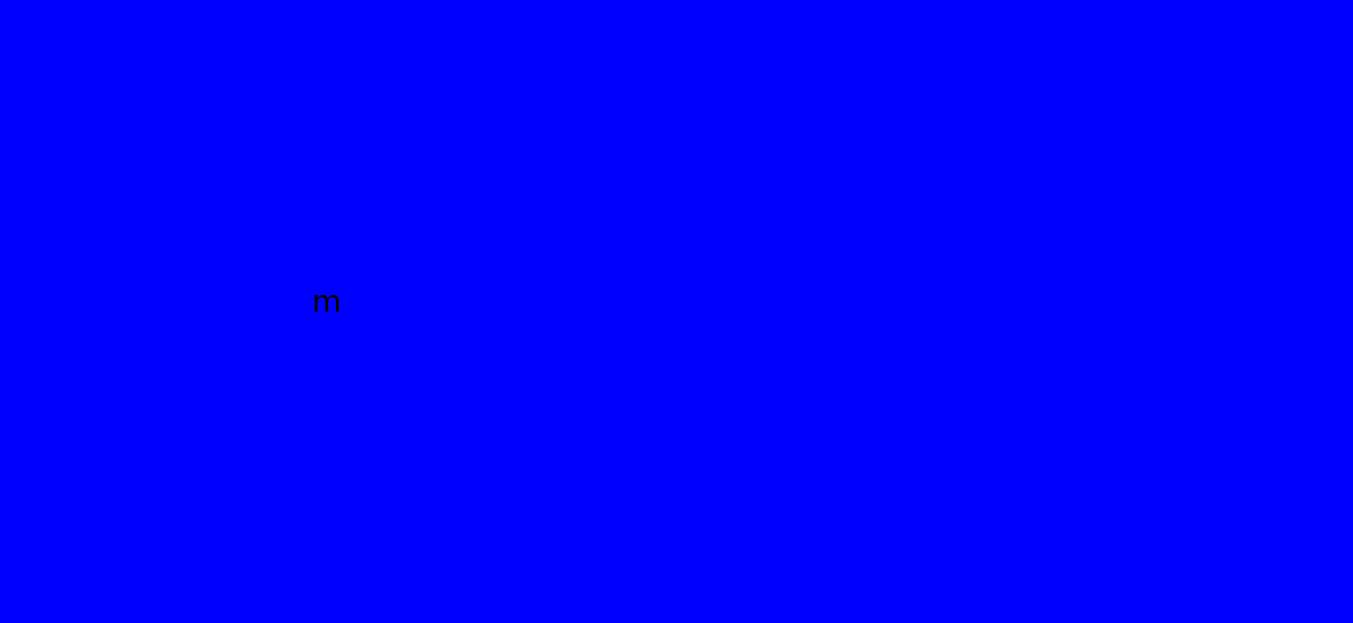

In [40]:
fig, axs = plt.subplots(1, 2)
plt.autoscale(False)
fig.patch.set_facecolor('blue')

axs[0].set_xlim([-0.4, 0.4])
axs[0].set_ylim([-0.4, 0.4])
axs[0].set_aspect(aspect='equal', adjustable='box')

axs[1].set_xlim([-0.4, 0.4])
axs[1].set_ylim([-0.4, 0.4])
axs[1].set_aspect(aspect='equal', adjustable='box')

m_text = axs[0].text(0,0, "m",fontsize=30)


############################
#axs[0].scatter(data[:,0],data[:,1],c=label_colors(data[:,2],0.02),s = 7)
#axs[1].scatter(data[:,0],data[:,1],c=right_wrong_colors(E_out.reshape(-1),0.02),s = 7)




In [41]:
#Initial setup of facecolors and edgecolors
edge_colors = np.ones((sample_size_max,4))
edge_colors[:,3] = 0  #setting all alphas to 0

#initial 4 points:
#edge_colors[:4,:3] = 0
#edge_colors[:4,3] = 1

real_labels = label_colors(training_data[:,2],0.00)
red_green_labels = right_wrong_colors(E_in.reshape(-1),0.00)

#initial 4 points
#real_labels[:4,3] = 1
#red_green_labels[:4,3] = 1

true_labels = axs[0].scatter(training_data[:,0],training_data[:,1],c=real_labels,s = 250,edgecolors=edge_colors)
red_green_labels = axs[1].scatter(training_data[:,0],training_data[:,1],c=red_green_labels,s = 250)

In [42]:
#Calculate all the E_ins beforehand
frames = sample_size_max 
training_errors = []
redpoints_count = []
for i in range(frames):
    x = E_in[0,:i+1]
    training_error = 1 - np.sum(x)/x.shape[0]
    training_errors.append(training_error)
    redpoints_count.append(x.shape[0]-np.sum(x))

# Initial 4 points
training_error_4_points = training_errors[3]
redpoints_count_at_4 = redpoints_count[3]
for i in range(3):
    training_errors[i] = training_error_4_points
    redpoints_count[i] = redpoints_count_at_4

In [43]:

fc1 = true_labels.get_facecolors()
fc2 = red_green_labels.get_facecolors()

In [44]:
def update(i):
    global fc1,fc2,edge_colors
    
    fc1[:,3][i] = 1
    true_labels.set_facecolors(fc1)
    
    edge_colors[i][:3] = 0
    edge_colors[i][3] = 1
    true_labels.set_edgecolors(edge_colors)
    
    fc2[:,3][i] = 1
    red_green_labels.set_facecolors(fc2)
    
    m_text.set_text(str(i+1))
    
    return true_labels,red_green_labels,
    
    

In [45]:
ani = animation.FuncAnimation(fig, update,frames=frames, 
                                         interval=30, blit=True, repeat=False)
file_name =  "m0to" + str(sample_size_max) +"_"+name +"_hypo"+str(specific_hypothesis)
ani.save(videos_path +file_name+'.mp4', fps=10, extra_args=['-vcodec', 'libx264'],savefig_kwargs=dict(facecolor='blue'))

# Latex

In [46]:
cell_data = np.c_[training_errors[4],true_error].T

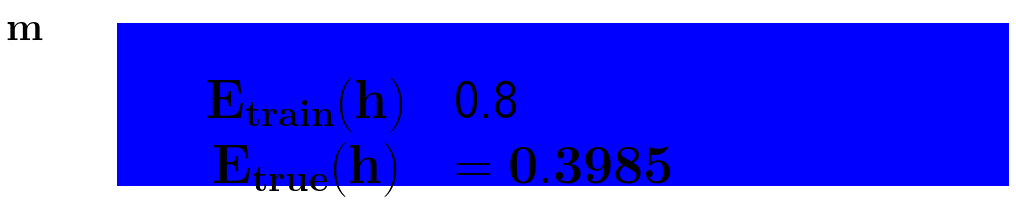

In [47]:
almosttable_rc = {"axes.spines.left" : False,
      "axes.spines.right" : False,
      "axes.spines.bottom" : False,
      "axes.spines.top" : False,
      "xtick.bottom" : False,
      "xtick.labelbottom" : False,
      "ytick.labelleft" : False,
      "ytick.left" : False,
      'savefig.facecolor':'blue',
      'axes.facecolor' : 'blue',
      "figure.figsize" : (16,3),
      "savefig.dpi" : 119,
      'text.usetex' : True,
      'text.latex.preamble': r'\boldmath',
      }


height = 0.4
width = 0.3


with plt.rc_context(almosttable_rc):
    fig_table, ax = plt.subplots()

    

    # Hide axes
    ax.xaxis.set_visible(False) 
    ax.yaxis.set_visible(False)


    rows = (r'$\mathbf{E_{ train}(h)}$', r'$\mathbf{E_{ true}(h)}$')
    columns = [r'$\mathbf{}$' ]



    the_table = ax.table(cellText = cell_data,
                          rowLabels=rows,
                          #rowColours = rcolors,
                          colLabels=columns,
                          cellLoc='left',
                          loc='center',
                          colWidths=[width for x in columns],
                          

                          )
    
    the_table.set_fontsize(80)

    

    cellDict = the_table.get_celld()

    for i in range(0,len(columns)):
        for j in range(0,len(rows)+1):
            cellDict[(j,i)].set_height(height)
    for i in range(1,3):
      cellDict[(i,-1)].set_height(height)

    for i in range(1,3):
      cellDict[(i,-1)].set_facecolor('blue')
      cellDict[(i,-1)].visible_edges = ''

      cellDict[(i,0)].set_facecolor('blue')
      cellDict[(i,0)].visible_edges = ''
      cellDict[(i,-1)]._loc = 'center'
    for i in range(1):
      true_txt = '{:.4f}'.format(true_error[0])
      cellDict[(2,i)].get_text().set_text(r'$\mathbf{'+' = '+str(true_txt)+'}$')

    
    c=the_table.get_celld()[(0,0)]
    c.set_facecolor('blue')
    c.visible_edges = ''
  

    m_text = ax.text(0.03,0.8, "$\mathbf{m}$", transform=plt.gcf().transFigure,ha="left",fontsize=40)#Displaying the labels
    


In [48]:
 def update(i):
      global training_errors,redpoints_count
      #train_err = "%.2f" % training_errors[i]
      #true_err = "%.2f" % true_error[0]
   



      for x in range(1):
        training_txt = '{:.4f}'.format(training_errors[i])


        the_table.get_celld()[(1,x)].get_text().set_text(r'$\mathbf{'+' = '+str(training_txt)+'}$' )



      text_m = r'$\mathbf{m = '+str(i+1)+'}$'
      m_text.set_text(text_m)

      


      return the_table,

In [49]:
ani = animation.FuncAnimation(fig_table, update,frames=frames, 
                                         interval=10, blit=True, repeat=False)
latex_name = "almosttable_"+ file_name
ani.save(videos_path +latex_name+'.mp4', fps=10, extra_args=['-vcodec', 'libx264'],savefig_kwargs=dict(facecolor='blue'))